In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from aind_dynamic_foraging_basic_analysis.plot import plot_fip as pf
from aind_dynamic_foraging_basic_analysis.plot import plot_foraging_session as pb
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import seaborn as sns
from scipy import stats

In [2]:
from importlib import reload


# get the data, get the analysis specifications

In [3]:

import json
from pathlib import Path
import os

DATA_PATH: Path = Path("/data")  # TODO: don't hardcode
ANALYSIS_BUCKET = os.getenv("ANALYSIS_BUCKET")


input_model_paths = tuple(DATA_PATH.glob('job_dict/*'))
print(f"Found {len(input_model_paths)} input job models to run analysis on.")
analysis_specs = None

analysis_spec_path = tuple(DATA_PATH.glob("analysis_parameters.json"))
if analysis_spec_path:
    with open(analysis_spec_path[0], "r") as f:
        analysis_specs = json.load(f)

from analysis_pipeline_utils.analysis_dispatch_model import AnalysisDispatchModel
import utils as utils
from analysis_model import (
    SummaryPlotsAnalysisSpecification, SummaryPlotsAnalysisSpecificationCLI
)
for model_path in input_model_paths:
    with open(model_path, "r") as f:
        analysis_dispatch_inputs = AnalysisDispatchModel.model_validate(json.load(f))
    
    analysis_specification = SummaryPlotsAnalysisSpecification.model_validate(analysis_specs).model_dump()

Found 1 input job models to run analysis on.


# get the data and set them up right

In [4]:
import rachel_analysis_framework_utils as r_utils
import analysis_util
from plots import summary_plots
from aind_dynamic_foraging_basic_analysis.metrics import trial_metrics



In [5]:


parameters = analysis_specification

(df_sess, df_trials, df_events, df_fip) = r_utils.get_nwb_processed(analysis_dispatch_inputs.file_location[0], **parameters)


Saving channels: ['G_0_dff-bright_mc-iso-IRLS', 'G_1_dff-bright_mc-iso-IRLS', 'R_1_dff-bright_mc-iso-IRLS', 'G_2_dff-bright_mc-iso-IRLS', 'R_2_dff-bright_mc-iso-IRLS']
CURRENTLY RUNNING 1/1: 800886_2025-08-21
--------------------------------------------------
Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
Retrieving foraging model QLearning_L1F1_CK1_softmax
Query: {'analysis_spec.analysis_name': 'MLE fitting', 'analysis_spec.analysis_ver': 'first version @ 0.10.0', 'subject_id': '800886', 'session_date': '2025-08-21', 'analysis_results.fit_settings.agent_alias': 'QLearning_L1F1_CK1_softmax'}
Found 1 MLE fitting records!
Found 1 successful MLE fitting!


Get latent variables from s3: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


In [6]:
# TODO: refactor this out to r_utils. 

##### PART I: REWARD #######
df_trials['reward_all'] = df_trials['earned_reward'] + df_trials['extra_reward']
# Compute num_reward_past and num_no_reward_past
df_trials['rewarded_prev'] = df_trials.groupby('ses_idx')['reward_all'].shift(1)  # Shift to look at past values

df_trials['num_reward_past'] = df_trials.groupby(
                        (df_trials['rewarded_prev'] != df_trials['reward_all']).cumsum()).cumcount() + 1

# Set 'NA' for mismatched reward types
df_trials.loc[df_trials['reward_all'] == 0, 'num_reward_past'] = df_trials.loc[df_trials['reward_all'] == 0, 'num_reward_past']* -1 

##### PART II: BINNING RPE #######
# get RPE binned columns. 
RPE_binned3_label_names = [str(np.round(i,2)) for i in np.arange(-1,0.99,1/3)]

bins = np.arange(-1,1.01,1/3)
bins[-1] = 1.001

df_trials['RPE-binned3'] = pd.cut(df_trials['RPE_earned'],# all versus earned not a huge difference
                    bins = bins, right = True, labels=RPE_binned3_label_names)

##### PART III: BINNING QCHOSEN #######
bins = [0.0, 1/3, 2/3, 1.01]
q_labels = ["Qch 0", "Qch 0.33", "Qch 0.66"]

q_bin = pd.cut(df_trials['Q_chosen'], bins=bins, labels=q_labels, include_lowest=True, right=True)
reward_label = df_trials['earned_reward'].map({True: "R+", False: "R-"})

# build combined label series (None where q_bin is NA)
reward_Qcat_series = pd.Series(
    np.where(q_bin.isna(), None, reward_label.astype(str) + " (" + q_bin.astype(str) + ")"),
    index=df_trials.index
)

# ordered categories you requested
Qch_binned3_label_names = [
    "R- (Qch 0)", "R- (Qch 0.33)", "R- (Qch 0.66)",
    "R+ (Qch 0)", "R+ (Qch 0.33)", "R+ (Qch 0.66)"
]

# assign final ordered categorical to dataframe (no intermediate column left behind)
df_trials['Qch-binned3'] = pd.Categorical(reward_Qcat_series, categories=Qch_binned3_label_names, ordered=True)

##### PART IV: GETTING STAY/LEAVE #######
_choice_shifted = df_trials.groupby('ses_idx')['choice'].shift(1)
df_trials['stay'] = df_trials['choice'] == _choice_shifted
df_trials['switch'] = df_trials['choice'] != _choice_shifted
df_trials['response_time'] = df_trials['choice_time_in_trial'] -  df_trials['goCue_start_time_in_trial']


(df_sess, nwbs_by_week) = analysis_util.get_dummy_nwbs_by_week(df_sess, df_trials, df_events, df_fip) 


# TODO: will need to refactor code so there's flexibility on the plots that come out
#       consult alex? or figure it out on my own. 
# get average activity 
data_column = 'data_z_norm'
alignment_event='choice_time_in_session'
rpe_slope_dict = {}
for channel in list(analysis_specification["channels"].keys()):
    avg_signal_col = summary_plots.output_col_name(channel, data_column, alignment_event)
    for nwb_week in nwbs_by_week:
    
        nwb_week = trial_metrics.get_average_signal_window_multi(
                        nwb_week,
                        alignment_event='choice_time_in_session',
                        offsets=[0.33, 1],
                        channel=channel,
                        data_column=data_column,
                        output_col = avg_signal_col
                    )

/src/aind-dynamic-foraging-basic-analysis/src/aind_dynamic_foraging_basic_analysis/metrics/trial_metrics.py:348: UserWarning: G_0 channel not found in df_fip. Returning original df_trials.
  warnings.warn(f"{channel} channel not found in df_fip. Returning original df_trials.")
/src/aind-dynamic-foraging-basic-analysis/src/aind_dynamic_foraging_basic_analysis/metrics/trial_metrics.py:348: UserWarning: G_1 channel not found in df_fip. Returning original df_trials.
  warnings.warn(f"{channel} channel not found in df_fip. Returning original df_trials.")
/src/aind-dynamic-foraging-basic-analysis/src/aind_dynamic_foraging_basic_analysis/metrics/trial_metrics.py:348: UserWarning: R_1 channel not found in df_fip. Returning original df_trials.
  warnings.warn(f"{channel} channel not found in df_fip. Returning original df_trials.")
/src/aind-dynamic-foraging-basic-analysis/src/aind_dynamic_foraging_basic_analysis/metrics/trial_metrics.py:348: UserWarning: G_2 channel not found in df_fip. Returni

In [11]:
reload(pb)

<module 'aind_dynamic_foraging_basic_analysis.plot.plot_foraging_session' from '/src/aind-dynamic-foraging-basic-analysis/src/aind_dynamic_foraging_basic_analysis/plot/plot_foraging_session.py'>

In [30]:
df_fip

,index,timestamps,data,event,raw_timestamps,ses_idx,data_z,data_norm,data_z_norm,week_interval
0,60701,-0.994784,0.001281,G_0_dff-bright_mc-iso-IRLS,3.541306e+06,800886_2025-08-21,0.204919,0.001964,0.354123,1
1,60702,-0.994784,0.032864,G_1_dff-bright_mc-iso-IRLS,3.541306e+06,800886_2025-08-21,0.420408,-0.001680,-0.074019,1
2,60703,-0.994784,0.057341,G_2_dff-bright_mc-iso-IRLS,3.541306e+06,800886_2025-08-21,0.597459,0.002662,0.074141,1
3,60704,-0.961446,0.008450,R_1_dff-bright_mc-iso-IRLS,3.541306e+06,800886_2025-08-21,1.082812,0.006618,0.912867,1
4,60705,-0.961446,0.006614,R_2_dff-bright_mc-iso-IRLS,3.541306e+06,800886_2025-08-21,0.856858,0.006620,0.940388,1
...,...,...,...,...,...,...,...,...,...,...
449208,509909,4491.087962,0.008294,R_2_dff-bright_mc-iso-IRLS,3.545798e+06,800886_2025-08-21,1.095536,0.007494,1.064539,1
449209,509910,4491.087962,-0.007785,R_1_dff-bright_mc-iso-IRLS,3.545798e+06,800886_2025-08-21,-1.156739,-0.005714,-0.788243,1
449210,509911,4491.104384,0.016063,G_2_dff-bright_mc-iso-IRLS,3.545798e+06,800886_2025-08-21,-0.552180,-0.000732,-0.020383,1
449211,509912,4491.104384,0.013051,G_1_dff-bright_mc-iso-IRLS,3.545798e+06,800886_2025-08-21,-0.452361,0.005146,0.226700,1


# new plotting

In [ ]:

def sliding_window_corr(
    df_fip: pd.DataFrame,
    signal1name: str,
    signal2name: str,
    signaldict: dict,
    value_col: str = "data_z",
    fs: float = 20.0,          # Hz
    window_sec: float = 1.0,
    step_sec: float = 0.1,
    min_valid_frac: float = 0.8,
):
    """
    df_fip is long-form: rows are (timestamp, value, event==signal_name).
    Computes sliding-window Pearson correlation across TIME samples.
    fs : float, default 20.0
        Sampling rate of the signals in Hz.
        This is used to convert window size and step size from seconds
        to number of samples. For 20 Hz photometry, fs=20.0.

    window_sec : float, default 1.0
        Length of the sliding window in seconds.
        Correlation at each time point is computed using samples within
        this window. For photometry, values between 0.75–1.5 s are typical.

    step_sec : float, default 0.1
        Step size between successive sliding windows in seconds.
        Smaller values give smoother correlation traces at higher cost.

    min_valid_frac : float, default 0.8
        Minimum fraction of finite (non-NaN) samples required within
        a window for correlation to be computed. Windows with too many
        NaNs are skipped.
    

    Returns a dict with:
      t         : seconds from start (aligned samples)
      s1, s2    : aligned signal vectors
      t_centers : window-center times (sec from start)
      r         : sliding-window Pearson r
    """
    # Extract the two signals with timestamps
    df1 = df_fip.loc[df_fip['event'] == signal1name, ['timestamps', value_col]].dropna()
    df2 = df_fip.loc[df_fip['event'] == signal2name, ['timestamps', value_col]].dropna()

    if df1.empty or df2.empty:
        raise ValueError("One or both signals not found (or all NaN) in df_fip.")

    # Align by timestamp (inner join)
    merged = (
        df1.rename(columns={value_col: "s1"})
           .merge(df2.rename(columns={value_col: "s2"}), on='timestamps', how="inner")
           .sort_values('timestamps')
    )

    t_abs = merged['timestamps'].to_numpy(dtype=float)
    s1 = merged["s1"].to_numpy(dtype=float)
    s2 = merged["s2"].to_numpy(dtype=float)

    if len(t_abs) < 10:
        raise ValueError("Too few aligned samples after merging on timestamps.")

    # Time axis for plotting / window centers (no trel): seconds from start
    t = t_abs - t_abs[0]

    # Sliding window params (in samples)
    win = int(round(window_sec * fs))
    step = int(round(step_sec * fs))
    if win < 5:
        raise ValueError("window_sec too small; need at least ~5 samples.")
    if step < 1:
        raise ValueError("step_sec too small; must be >= 1/fs.")

    centers = np.arange(win // 2, len(t) - win // 2, step)
    t_centers = t[centers]

    r = np.full(len(centers), np.nan)
    for i, c in enumerate(centers):
        lo = c - win // 2
        hi = c + win // 2

        x = s1[lo:hi]
        y = s2[lo:hi]
        good = np.isfinite(x) & np.isfinite(y)

        if good.mean() < min_valid_frac or good.sum() < 5:
            continue

        r[i] = stats.pearsonr(x[good], y[good]).statistic

    return {
        "t": t,
        "s1": s1,
        "s2": s2,
        "t_centers": t_centers,
        "r": r,
        "signal1name": signaldict[signal1name[:3]],
        "signal2name": signaldict[signal2name[:3]],
        "fs": fs,
        "window_sec": window_sec,
        "step_sec": step_sec,
    }


In [ ]:
out = sliding_window_corr(
    df_fip,
    'G_1_dff-bright_mc-iso-IRLS',
    'G_2_dff-bright_mc-iso-IRLS',
    signaldict=parameters['channels'],
    fs = 20,  # 20 Hz
    window_sec=1.5,   # good for photometry
    step_sec=0.05
)

TypeError: sliding_window_corr() got an unexpected keyword argument 'signal_dict'

In [41]:
def plot_signals_and_sliding_corr(
    result: dict,
    figsize=(16, 6),
    colors=("green", "darkgreen", "black"),
):
    """
    Plots:
      1) Signal 1
      2) Signal 2
      3) Sliding-window Pearson correlation

    Each in its own subplot, shared x-axis.

    Parameters
    ----------
    result : dict
        Output of sliding_window_corr_df_fip
    figsize : tuple
        Figure size (make wide/long)
    colors : tuple
        (color_signal1, color_signal2, color_corr)
    """
    t = result["t"]
    s1 = result["s1"]
    s2 = result["s2"]
    t_centers = result["t_centers"]
    r = result["r"]
    signal1name = result.get("signal1name", "Signal 1")
    signal2name = result.get("signal2name", "Signal 2")

    c1, c2, c3 = colors

    fig, axes = plt.subplots(
        nrows=3,
        ncols=1,
        sharex=True,
        figsize=figsize,
        constrained_layout=True,
    )

    # --- G0 ---
    axes[0].plot(t, s1, color=c1, linewidth=1.5)
    axes[0].set_ylabel(signal1name)
    axes[0].set_title(signal1name)
    axes[0].axhline(0, linewidth=0.5, alpha=0.5)

    # --- G1 ---
    axes[1].plot(t, s2, color=c2, linewidth=1.5)
    axes[1].set_ylabel(signal2name)
    axes[1].set_title(signal2name)
    axes[1].axhline(0, linewidth=0.5, alpha=0.5)

    # --- Sliding-window correlation ---
    axes[2].plot(t_centers, r, color=c3, linewidth=2)
    axes[2].set_ylabel("Pearson r")
    axes[2].set_xlabel("Time (s)")
    axes[2].set_title(f"Sliding-window correlation of {signal1name} and {signal2name}")
    axes[2].axhline(0, linestyle="--", linewidth=1)

    return fig, axes

(<Figure size 1600x600 with 3 Axes>,
 array([<Axes: title={'center': 'G_1_dff-bright_mc-iso-IRLS'}, ylabel='G_1_dff-bright_mc-iso-IRLS'>,
        <Axes: title={'center': 'G_2_dff-bright_mc-iso-IRLS'}, ylabel='G_2_dff-bright_mc-iso-IRLS'>,
        <Axes: title={'center': 'Sliding-window correlation of G_1_dff-bright_mc-iso-IRLS and G_2_dff-bright_mc-iso-IRLS'}, xlabel='Time (s)', ylabel='Pearson r'>],
       dtype=object))

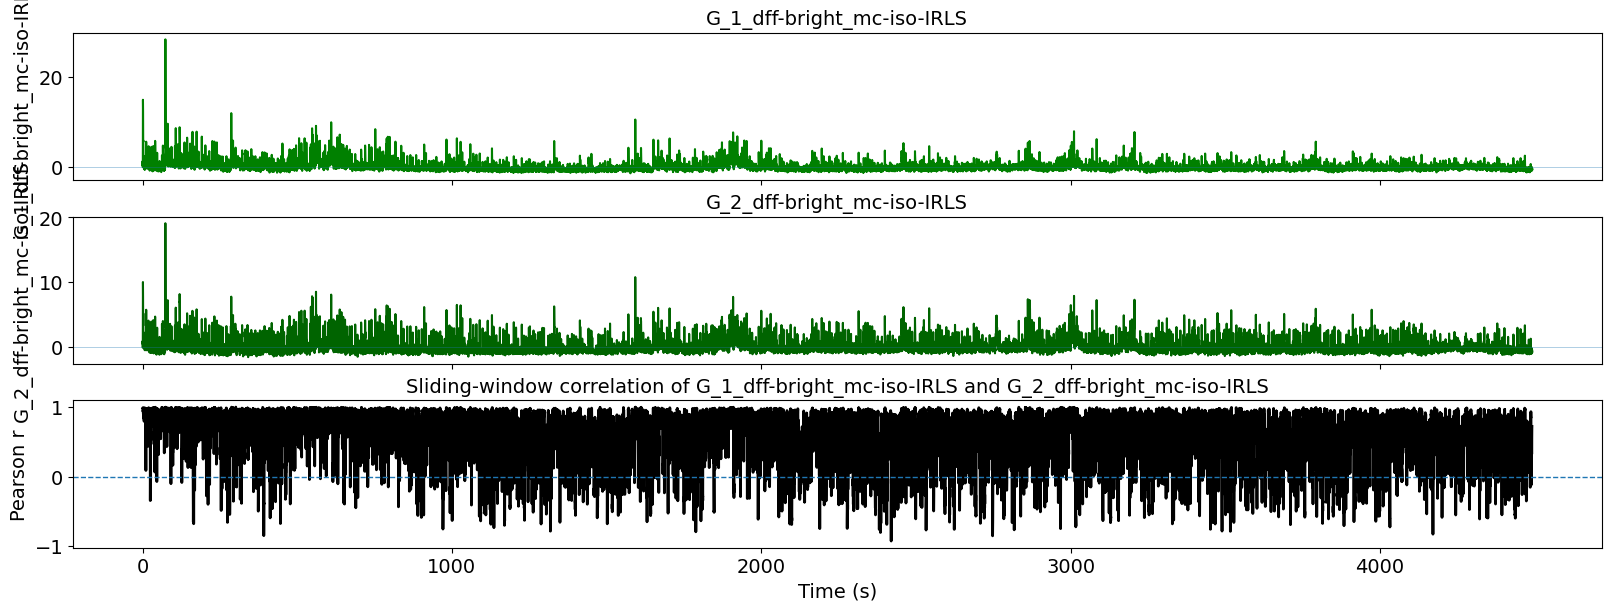

In [42]:
plot_signals_and_sliding_corr(out)

In [19]:
r_mean

array([], dtype=float64)

In [7]:
from aind_dynamic_foraging_data_utils import enrich_dfs
(df_fip_z, df_trials_fip) = enrich_dfs.enrich_fip_in_df_trials(df_fip, df_trials)

In [ ]:
# event locked correlations 

def as_1d_float(x):
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return None
    arr = np.asarray(x, dtype=float).ravel()
    if arr.size == 0:
        return None
    return arr

def build_trial_matrices_from_df_trials_fip(
    df_trials_fip: pd.DataFrame,
    data0_col="data_G_0",
    t0_col="timestamps_in_trial_G_0",
    data1_col="data_G_1",
    t1_col="timestamps_in_trial_G_1",
    trel=None,                 # optional: provide your own common grid
    dt=None,                   # optional: set dt (seconds) if trel is None
    t_pre=None, t_post=None,   # optional: auto-build trel from these if trel is None
    require_monotonic=True,
):
    """
    Returns
    -------
    trel : (n_time,)
    G0, G1 : (n_trials, n_time) arrays with NaNs where missing
    fs : inferred sampling rate (1/dt)
    keep_trials : boolean mask of trials kept
    """
    n_trials = len(df_trials_fip)

    # --- helper: convert a cell to 1D float array


    # --- gather all trial time axes to infer dt / range if needed
    t0_list, t1_list = [], []
    x0_list, x1_list = [], []
    keep = np.ones(n_trials, dtype=bool)

    for i, row in df_trials_fip.iterrows():
        t0 = as_1d_float(row.get(t0_col))
        x0 = as_1d_float(row.get(data0_col))
        t1 = as_1d_float(row.get(t1_col))
        x1 = as_1d_float(row.get(data1_col))

        if t0 is None or x0 is None or t1 is None or x1 is None:
            keep[i] = False
            t0_list.append(None); x0_list.append(None)
            t1_list.append(None); x1_list.append(None)
            continue

        if require_monotonic:
            if np.any(np.diff(t0) <= 0) or np.any(np.diff(t1) <= 0):
                keep[i] = False

        # also require matching lengths within each signal
        if len(t0) != len(x0) or len(t1) != len(x1):
            keep[i] = False

        t0_list.append(t0); x0_list.append(x0)
        t1_list.append(t1); x1_list.append(x1)

    if keep.sum() == 0:
        raise ValueError("No valid trials found (missing arrays or non-monotonic timestamps).")

    # --- Build common trel if not provided
    if trel is None:
        # infer dt if not provided
        if dt is None:
            dts = []
            for i in range(n_trials):
                if not keep[i]:
                    continue
                dts.append(np.median(np.diff(t0_list[i])))
                dts.append(np.median(np.diff(t1_list[i])))
            dt = float(np.nanmedian(dts))
            if not np.isfinite(dt) or dt <= 0:
                raise ValueError("Could not infer dt from timestamps_in_trial columns.")

        # infer range if not provided
        if t_pre is None or t_post is None:
            tmins = []
            tmaxs = []
            for i in range(n_trials):
                if not keep[i]:
                    continue
                tmins.append(np.nanmin(t0_list[i]))
                tmins.append(np.nanmin(t1_list[i]))
                tmaxs.append(np.nanmax(t0_list[i]))
                tmaxs.append(np.nanmax(t1_list[i]))
            tmin = float(np.nanpercentile(tmins, 90))  # conservative: typical coverage
            tmax = float(np.nanpercentile(tmaxs, 10))
            # if that percentile logic feels too clever, switch to min/max
            # tmin, tmax = float(np.nanmax(tmins)), float(np.nanmin(tmaxs))
            if tmax <= tmin:
                # fall back to global overlap
                tmin = float(np.nanmax([np.nanmin(t0_list[i]) for i in range(n_trials) if keep[i]] +
                                       [np.nanmin(t1_list[i]) for i in range(n_trials) if keep[i]]))
                tmax = float(np.nanmin([np.nanmax(t0_list[i]) for i in range(n_trials) if keep[i]] +
                                       [np.nanmax(t1_list[i]) for i in range(n_trials) if keep[i]]))
            trel = np.arange(tmin, tmax + 1e-12, dt)
        else:
            trel = np.arange(-float(t_pre), float(t_post) + 1e-12, float(dt))

    trel = np.asarray(trel, dtype=float)
    if trel.ndim != 1 or trel.size < 5:
        raise ValueError("trel must be a 1D array with at least ~5 samples.")

    dt_eff = float(np.median(np.diff(trel)))
    fs = 1.0 / dt_eff

    # --- interpolate each trial onto trel
    G0 = np.full((n_trials, trel.size), np.nan)
    G1 = np.full((n_trials, trel.size), np.nan)

    for i in range(n_trials):
        if not keep[i]:
            continue
        t0, x0 = t0_list[i], x0_list[i]
        t1, x1 = t1_list[i], x1_list[i]

        # interpolate onto trel
        G0[i, :] = np.interp(trel, t0, x0, left=np.nan, right=np.nan)
        G1[i, :] = np.interp(trel, t1, x1, left=np.nan, right=np.nan)

    # keep only rows that have at least some finite samples in both
    good_rows = np.isfinite(G0).sum(axis=1) > 5
    good_rows &= np.isfinite(G1).sum(axis=1) > 5

    return trel, G0[good_rows], G1[good_rows], fs, good_rows
def corr_at_lag(x, y, lag, zscore_within_window, min_valid_frac):
    if lag > 0:
        x2 = x[:-lag]
        y2 = y[lag:]
    elif lag < 0:
        x2 = x[-lag:]
        y2 = y[:lag]
    else:
        x2 = x
        y2 = y

    good = np.isfinite(x2) & np.isfinite(y2)
    if good.sum() < 5 or good.mean() < min_valid_frac:
        return np.nan

    a = x2[good]
    b = y2[good]

    # Pearson correlation
    if zscore_within_window:
        a = (a - a.mean()) / (a.std() + 1e-12)
        b = (b - b.mean()) / (b.std() + 1e-12)
        return float(np.mean(a * b))
    else:
        a = a - a.mean()
        b = b - b.mean()
        denom = (np.sqrt(np.sum(a*a)) * np.sqrt(np.sum(b*b)) + 1e-12)
        return float(np.sum(a*b) / denom)

def event_lagged_corr_map(
    G0: np.ndarray,
    G1: np.ndarray,
    fs: float,
    trel: np.ndarray,
    window_sec: float = 0.75,
    step_sec: float = 0.05,
    max_lag_sec: float = 1.5,
    min_valid_frac: float = 0.8,
    zscore_within_window: bool = True,
):
    """
    Returns:
      t_centers: (n_centers,) in seconds (relative to go cue)
      lags_sec:  (n_lags,) in seconds
      R:         (n_centers, n_lags) mean correlation across trials
    """
    assert G0.shape == G1.shape
    n_trials, n_time = G0.shape

    win = int(round(window_sec * fs))
    step = int(round(step_sec * fs))
    max_lag = int(round(max_lag_sec * fs))

    if win < 5:
        raise ValueError("window_sec too small.")
    if step < 1:
        raise ValueError("step_sec too small.")
    if max_lag < 0:
        raise ValueError("max_lag_sec must be >= 0.")

    lag_samps = np.arange(-max_lag, max_lag + 1)
    lags_sec = lag_samps / fs

    centers = np.arange(win // 2, n_time - (win - win // 2) + 1, step)
    t_centers = trel[centers]

    R = np.full((len(centers), len(lag_samps)), np.nan)

    
    for ci, c in enumerate(centers):
        start = c - win // 2
        stop = start + win

        vals = np.full((n_trials, len(lag_samps)), np.nan)
        for tr in range(n_trials):
            x = G0[tr, start:stop]
            y = G1[tr, start:stop]
            for li, lag in enumerate(lag_samps):
                vals[tr, li] = corr_at_lag(x, y, lag)

        R[ci, :] = np.nanmean(vals, axis=0)

    return t_centers, lags_sec, R

In [12]:
trel, G0, G1, fs, keep_trials = build_trial_matrices_from_df_trials_fip(
    df_trials_fip,
    data0_col="data_G_0_dff-bright_mc-iso-IRLS",
    t0_col="timestamps_in_trial_G_0_dff-bright_mc-iso-IRLS",
    data1_col="data_G_1_dff-bright_mc-iso-IRLS",
    t1_col="timestamps_in_trial_G_1_dff-bright_mc-iso-IRLS")

In [16]:
df_trials_fip

,trial,choice,rewarded_historyL,rewarded_historyR,side_bias,side_bias_confidence_interval,bait_left,bait_right,base_reward_probability_sum,reward_probabilityL,...,data_G_2_dff-bright_mc-iso-IRLS,data_z_G_2_dff-bright_mc-iso-IRLS,timestamps_in_trial_R_1_dff-bright_mc-iso-IRLS,timestamps_in_session_R_1_dff-bright_mc-iso-IRLS,data_R_1_dff-bright_mc-iso-IRLS,data_z_R_1_dff-bright_mc-iso-IRLS,timestamps_in_trial_R_2_dff-bright_mc-iso-IRLS,timestamps_in_session_R_2_dff-bright_mc-iso-IRLS,data_R_2_dff-bright_mc-iso-IRLS,data_z_R_2_dff-bright_mc-iso-IRLS
0,0,1.0,False,True,0.000000,"[0.0, 0.0]",True,True,0.8,0.7,...,"[0.05734125882380889, 0.058129622753225786, 0....","[0.5447374968246567, 0.5659589469045998, 0.590...","[-0.9614463998004794, -0.9114879998378456, -0....","[-0.9614463998004794, -0.9114879998378456, -0....","[0.008449658513848499, 0.01606119692544068, 0....","[1.078998837076713, 2.141478090160936, 1.90808...","[-0.9614463998004794, -0.9114879998378456, -0....","[-0.9614463998004794, -0.9114879998378456, -0....","[0.006613523050642839, 0.003844079244627081, -...","[0.8522607515916356, 0.45889375931970056, -0.2..."
1,1,2.0,False,False,0.000000,"[0.0, 0.0]",True,False,0.8,0.7,...,"[0.08821165993886328, 0.08904955712916114, 0.0...","[1.3757175198395235, 1.3982723231892689, 1.440...","[-0.9596416000276804, -0.9090943997725844, -0....","[9.688262400217354, 9.73880960047245, 9.788544...","[-0.00048466993391713337, -0.00110576958336912...","[-0.1681260019090904, -0.2548240458466478, -0....","[-0.9596416000276804, -0.9090943997725844, -0....","[9.688262400217354, 9.73880960047245, 9.788544...","[0.00017236524798999817, 0.0026788686484988436...","[-0.06263012507995151, 0.29338926828553763, 0...."
2,2,2.0,False,False,0.000000,"[0.0, 0.0]",True,True,0.8,0.7,...,"[0.03355383228339558, 0.03567488174654755, 0.0...","[-0.09558059234903755, -0.038485456942903604, ...","[-0.9593023997731507, -0.9094912000000477, -0....","[16.93855360010639, 16.98836479987949, 17.0387...","[-0.0028081642634700914, -0.004022548446929124...","[-0.49245787627093307, -0.661971308435161, -0....","[-0.9593023997731507, -0.9094912000000477, -0....","[16.93855360010639, 16.98836479987949, 17.0387...","[-0.00012958441231462404, -0.0005860921259835,...","[-0.10551853084343205, -0.17036009429555635, -..."
3,3,2.0,False,False,0.000000,"[0.0, 0.0]",True,True,0.8,0.7,...,"[0.020314399136429302, 0.023001893199217343, 0...","[-0.4519641851687851, -0.379621300156551, -0.3...","[-0.975929600186646, -0.9261888000182807, -0.8...","[26.488806399982423, 26.538547200150788, 26.58...","[-0.0030316745956184797, -0.001611125891206888...","[-0.5236572315019279, -0.3253657108108731, 0.1...","[-0.975929600186646, -0.9261888000182807, -0.8...","[26.488806399982423, 26.538547200150788, 26.58...","[0.021063701918879837, 0.01876360025270005, 0....","[2.90473908202125, 2.5780366328220836, 1.70650..."
4,4,2.0,False,False,0.000000,"[0.0, 0.0]",True,True,0.8,0.7,...,"[0.024333054257293246, 0.016896318900831698, 0...","[-0.34378865118792556, -0.5439732388334108, -0...","[-0.9758656001649797, -0.9261759999208152, -0....","[32.53882239991799, 32.588512000162154, 32.638...","[-0.0073782696300604585, -0.002803420974809814...","[-1.1303896416833117, -0.4917957701998058, -0....","[-0.9758656001649797, -0.9261759999208152, -0....","[32.53882239991799, 32.588512000162154, 32.638...","[-0.009538852275464083, -0.0050044498960074854...","[-1.4419946098193486, -0.7979359645841406, -0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,521,0.0,True,False,0.070214,"[-0.14657731568563206, 0.279960170753626]",True,False,0.8,0.4,...,"[0.0254118806392732, 0.022332472387834104, 0.0...","[-0.31474843339530456, -0.3976409986754212, -0...","[-0.977267200127244, -0.9272191999480128, -0.8...","[4460.687628800049, 4460.737676800229, 4460.78...","[0.0028601640465566237, 0.005909593460599964, ...","[0.2987726087386747, 0.7244362933929436, 1.328...","[-0.977267200127244, -0.927

In [13]:
t_centers, lags_sec, R = event_lagged_corr_map(
        G0, G1, fs, trel,
        window_sec=window_sec,
        step_sec=step_sec,
        max_lag_sec=max_lag_sec,
    )

NameError: name 'window_sec' is not defined

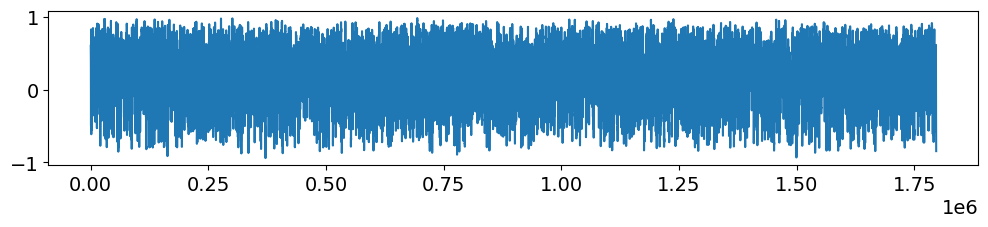

In [ ]:
plt.figure()
extent = [lags_sec[0], lags_sec[-1], t_centers[0], t_centers[-1]]
plt.imshow(R, aspect="auto", origin="lower", extent=extent)
plt.axhline(0, linewidth=1)  # go cue at t_rel=0 (y-axis is time-from-go)
plt.xlabel("Lag (s)  (positive => G_1 lags G_0)")
plt.ylabel("Time from go cue (s)")
plt.title("Event-locked lagged correlation R(time, lag)")
plt.colorbar(label="Correlation")
plt.show()

In [10]:
df_trials.columns.values

array(['trial', 'choice', 'rewarded_historyL', 'rewarded_historyR',
       'side_bias', 'side_bias_confidence_interval', 'bait_left',
       'bait_right', 'base_reward_probability_sum', 'reward_probabilityL',
       'reward_probabilityR', 'reward_random_number_left',
       'reward_random_number_right', 'left_valve_open_time',
       'right_valve_open_time', 'block_beta', 'block_min', 'block_max',
       'min_reward_each_block', 'delay_beta', 'delay_min', 'delay_max',
       'delay_duration', 'ITI_beta', 'ITI_min', 'ITI_max', 'ITI_duration',
       'response_duration', 'reward_consumption_duration', 'auto_waterL',
       'auto_waterR', 'auto_train_engaged', 'auto_train_curriculum_name',
       'auto_train_curriculum_version',
       'auto_train_curriculum_schema_version', 'auto_train_stage',
       'auto_train_stage_overridden', 'lickspout_position_x',
       'lickspout_position_y1', 'lickspout_position_y2',
       'lickspout_position_z', 'reward_size_left', 'reward_size_right',
      

In [13]:
df_fip

,index,timestamps,data,event,raw_timestamps,ses_idx,data_z,data_norm,data_z_norm,week_interval
0,60701,-0.994784,0.001281,G_0_dff-bright_mc-iso-IRLS,3.541306e+06,800886_2025-08-21,0.204919,0.001964,0.354123,1
1,60702,-0.994784,0.057341,G_2_dff-bright_mc-iso-IRLS,3.541306e+06,800886_2025-08-21,0.597459,0.002662,0.074141,1
2,60703,-0.994784,0.032864,G_1_dff-bright_mc-iso-IRLS,3.541306e+06,800886_2025-08-21,0.420408,-0.001680,-0.074019,1
3,60704,-0.961446,0.008450,R_1_dff-bright_mc-iso-IRLS,3.541306e+06,800886_2025-08-21,1.082812,0.006618,0.912867,1
4,60705,-0.961446,0.006614,R_2_dff-bright_mc-iso-IRLS,3.541306e+06,800886_2025-08-21,0.856858,0.006620,0.940388,1
...,...,...,...,...,...,...,...,...,...,...
449208,509909,4491.087962,-0.007785,R_1_dff-bright_mc-iso-IRLS,3.545798e+06,800886_2025-08-21,-1.156739,-0.005714,-0.788243,1
449209,509910,4491.087962,0.008294,R_2_dff-bright_mc-iso-IRLS,3.545798e+06,800886_2025-08-21,1.095536,0.007494,1.064539,1
449210,509911,4491.104384,0.000292,G_0_dff-bright_mc-iso-IRLS,3.545798e+06,800886_2025-08-21,0.026530,0.004155,0.749248,1
449211,509912,4491.104384,0.016063,G_2_dff-bright_mc-iso-IRLS,3.545798e+06,800886_2025-08-21,-0.552180,-0.000732,-0.020383,1


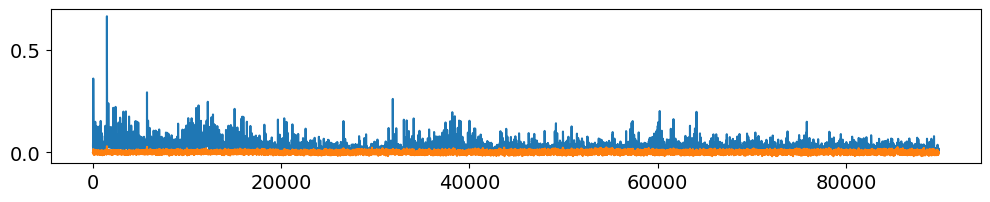

In [18]:
from scipy import stats

# select rows
g1 = df_fip[df_fip['event'] == 'G_1_dff-bright_mc-iso-IRLS']['data'].dropna().tolist()
g0 = df_fip[df_fip['event'] == 'G_0_dff-bright_mc-iso-IRLS']['data'].dropna().tolist()

plt.figure(figsize = (12,2))
plt.plot(g1)
plt.plot(g0)

In [24]:
r, p = stats.pearsonr(g0, g1)

In [26]:
p

0.0

In [11]:
df_fip

,index,timestamps,data,event,raw_timestamps,ses_idx,data_z,data_norm,data_z_norm,week_interval
0,60701,-0.994784,0.032864,G_1_dff-bright_mc-iso-IRLS,3.541306e+06,800886_2025-08-21,0.420408,-0.001680,-0.074019,1
1,60702,-0.994784,0.001281,G_0_dff-bright_mc-iso-IRLS,3.541306e+06,800886_2025-08-21,0.204919,0.001964,0.354123,1
2,60703,-0.994784,0.057341,G_2_dff-bright_mc-iso-IRLS,3.541306e+06,800886_2025-08-21,0.597459,0.002662,0.074141,1
3,60704,-0.961446,0.008450,R_1_dff-bright_mc-iso-IRLS,3.541306e+06,800886_2025-08-21,1.082812,0.006618,0.912867,1
4,60705,-0.961446,0.006614,R_2_dff-bright_mc-iso-IRLS,3.541306e+06,800886_2025-08-21,0.856858,0.006620,0.940388,1
...,...,...,...,...,...,...,...,...,...,...
449208,509909,4491.087962,-0.007785,R_1_dff-bright_mc-iso-IRLS,3.545798e+06,800886_2025-08-21,-1.156739,-0.005714,-0.788243,1
449209,509910,4491.087962,0.008294,R_2_dff-bright_mc-iso-IRLS,3.545798e+06,800886_2025-08-21,1.095536,0.007494,1.064539,1
449210,509911,4491.104384,0.016063,G_2_dff-bright_mc-iso-IRLS,3.545798e+06,800886_2025-08-21,-0.552180,-0.000732,-0.020383,1
449211,509912,4491.104384,0.000292,G_0_dff-bright_mc-iso-IRLS,3.545798e+06,800886_2025-08-21,0.026530,0.004155,0.749248,1


In [7]:
import plots.summary_plots as summary_plots

In [8]:
nwbs_by_week[0]

[726649_2024-09-12, 726649_2024-09-16]

2026-01-07 02:00:06,346 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/src/aind-dynamic-foraging-basic-analysis/src/aind_dynamic_foraging_basic_analysis/plot/plot_fip.py:219: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
2026-01-07 02:00:07,051 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2026-01-07 02:00:07,799 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2026-01-07 02:00:08,543 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2026-01-07 02:00:08,763 - INFO - Using categorical

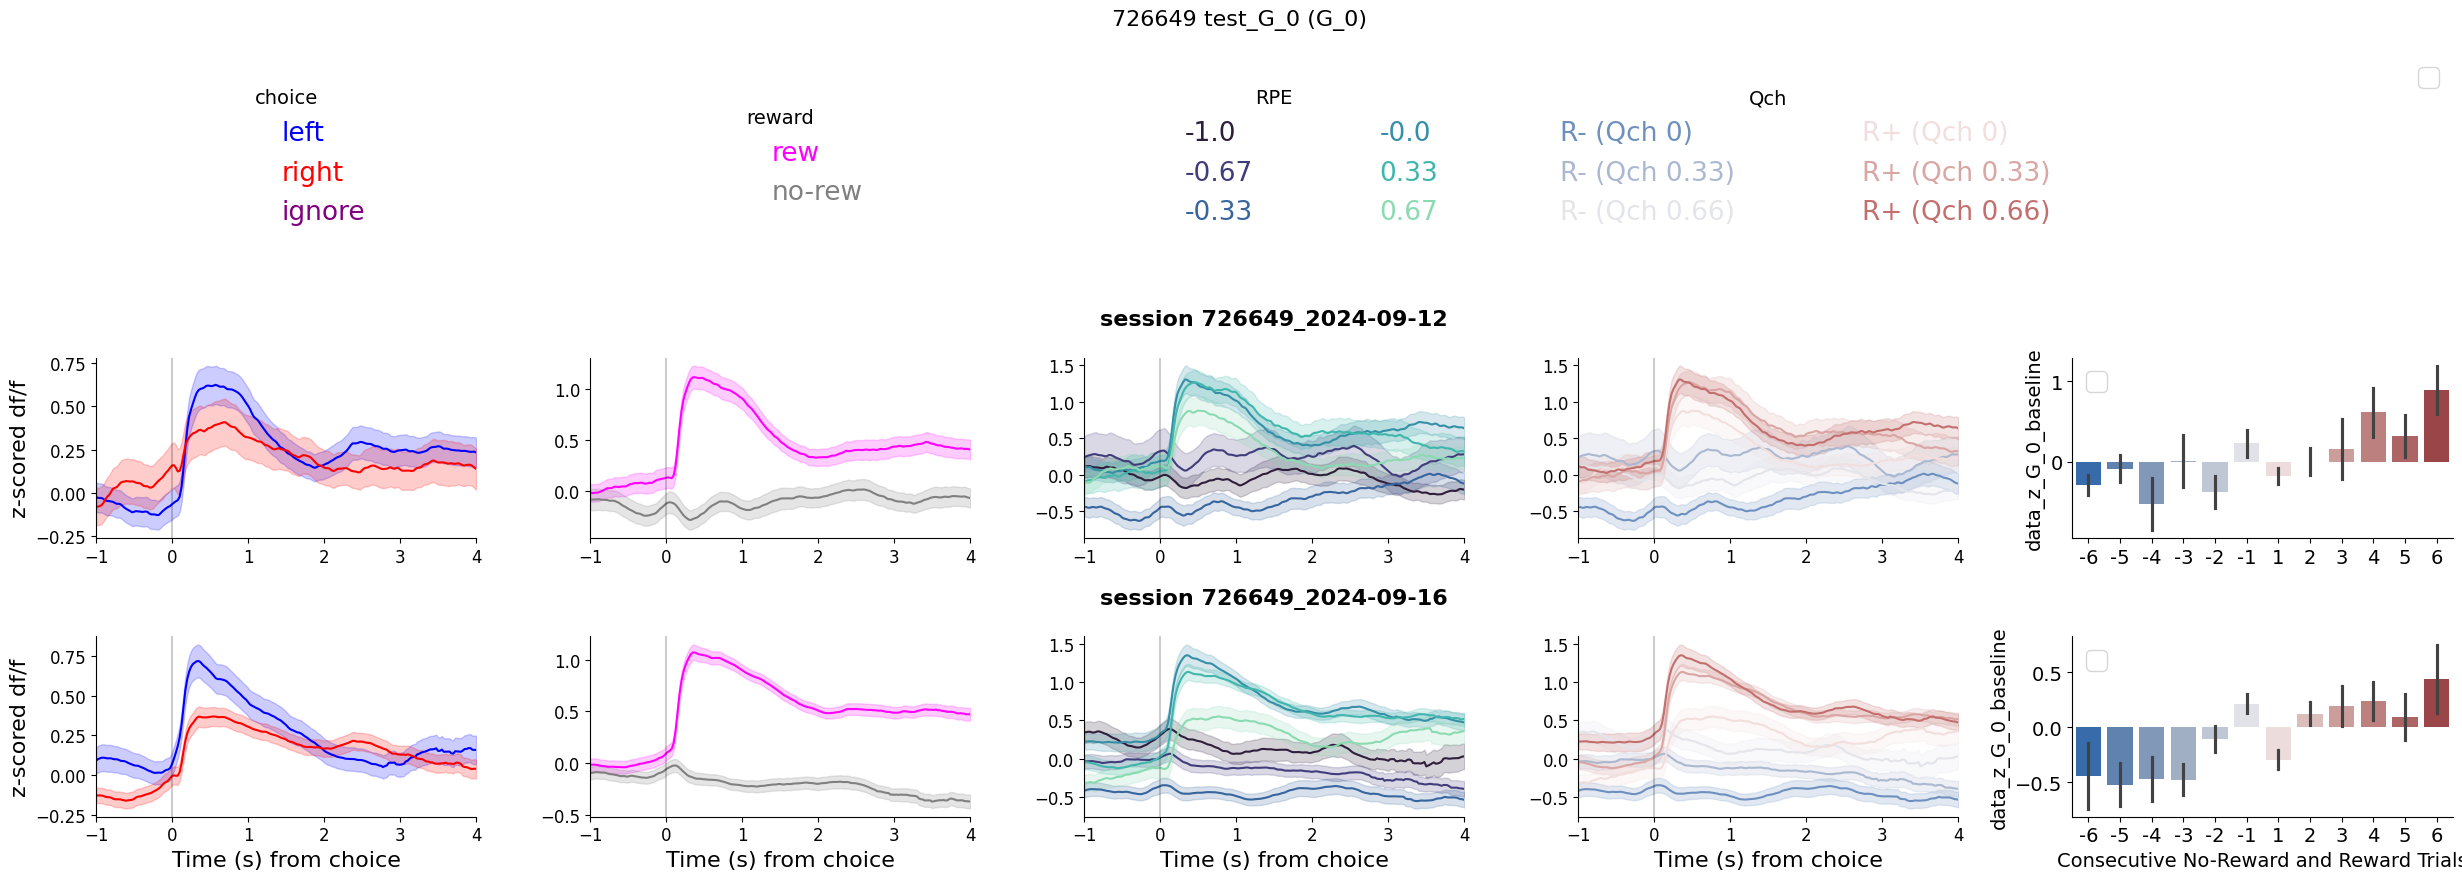

In [9]:
summary_plots.plot_all_sess_PSTH(df_sess, nwbs_by_week[0], "G_0", "test_G_0", loc=None)

In [11]:
nwbs_by_week[0][0].df_fip

,index,timestamps,data,event,raw_timestamps,ses_idx,data_z,data_norm,data_z_norm,week_interval
0,36959,-0.989299,2521.088553,R_0,1.055352e+07,726649_2024-09-12,0.788428,35.967171,0.074388,1
1,36960,-0.972672,1153.167617,G_1,1.055352e+07,726649_2024-09-12,-0.126137,15.073204,0.126983,1
2,36961,-0.972672,1960.953368,G_0,1.055352e+07,726649_2024-09-12,-0.357395,213.193782,0.488830,1
3,36962,-0.939315,2527.654428,R_0,1.055352e+07,726649_2024-09-12,0.802008,42.533045,0.087968,1
4,36963,-0.922656,1962.031088,G_0,1.055352e+07,726649_2024-09-12,-0.354923,214.271503,0.491301,1
...,...,...,...,...,...,...,...,...,...,...
262856,299815,4379.920256,985.687571,G_1,1.055790e+07,726649_2024-09-12,-1.537059,52.765336,0.444517,1
262857,299816,4379.953574,1525.632829,R_0,1.055790e+07,726649_2024-09-12,-1.270400,44.281641,0.091584,1
262858,299817,4379.970272,981.527936,G_1,1.055790e+07,726649_2024-09-12,-1.572102,48.605701,0.409475,1
262859,299818,4379.970272,1590.383420,G_0,1.055790e+07,726649_2024-09-12,-1.207071,254.669430,0.583929,1


2026-01-07 02:02:40,623 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2026-01-07 02:02:42,461 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2026-01-07 02:02:44,220 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2026-01-07 02:02:46,055 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2026-01-07 02:02:47,874 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2026-01-07 02:02:49,465 - WARNING -

[<Axes: ylabel='z-scored df/f'>,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: ylabel='data_z_G_1_baseline'>]

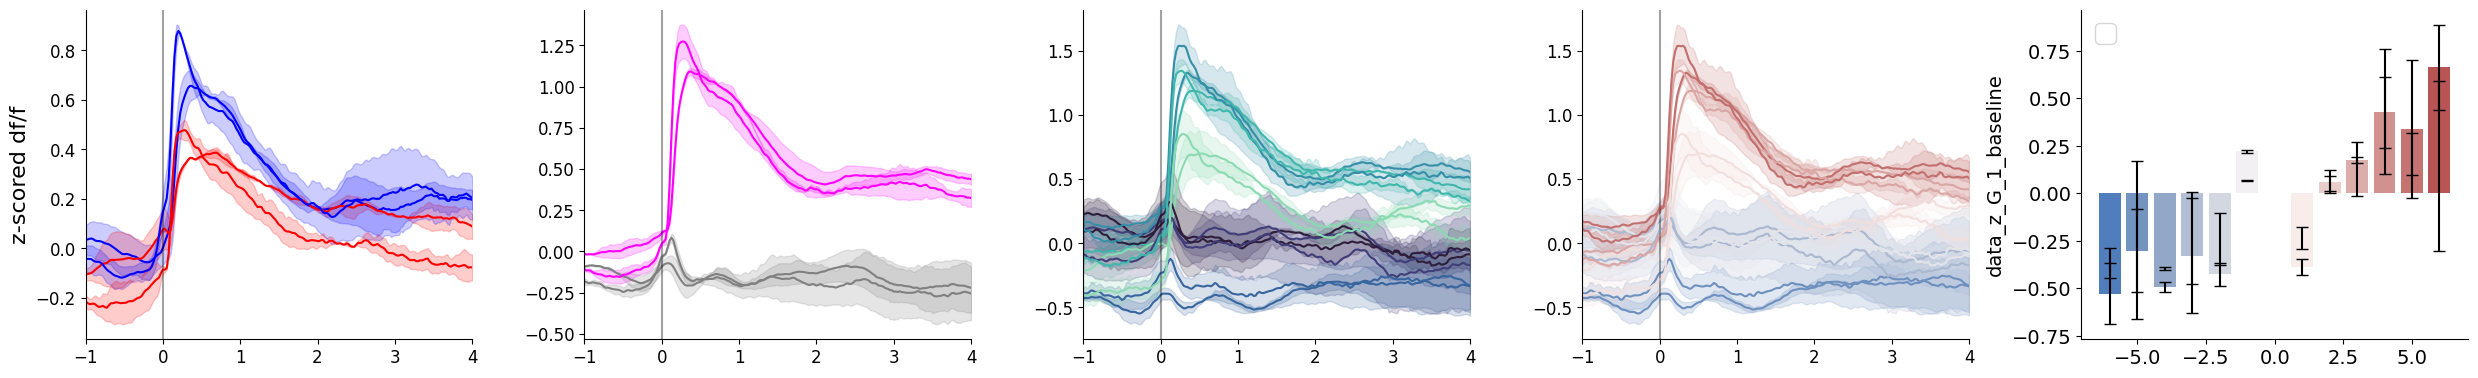

In [12]:
# make figure with 1 row and 5 columns and call the plotting helper
nwb = nwbs_by_week[0][0]
fig = plt.figure(figsize=(5 * 5, 8))



# bottom row: actual PSTH panels (1 x 5)
psth_axes = [fig.add_subplot(2, 5, 5 + i + 1) for i in range(5)]

summary_plots.plot_row_panels_PSTH(nwbs_by_week[0], "G_0", psth_axes , legend_panel = False)
summary_plots.plot_row_panels_PSTH(nwbs_by_week[0], "G_1", psth_axes , legend_panel = False)

## existing plots

/src/aind-dynamic-foraging-basic-analysis/src/aind_dynamic_foraging_basic_analysis/plot/plot_foraging_session.py:452: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
2025-12-17 07:35:02,527 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2025-12-17 07:35:04,032 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


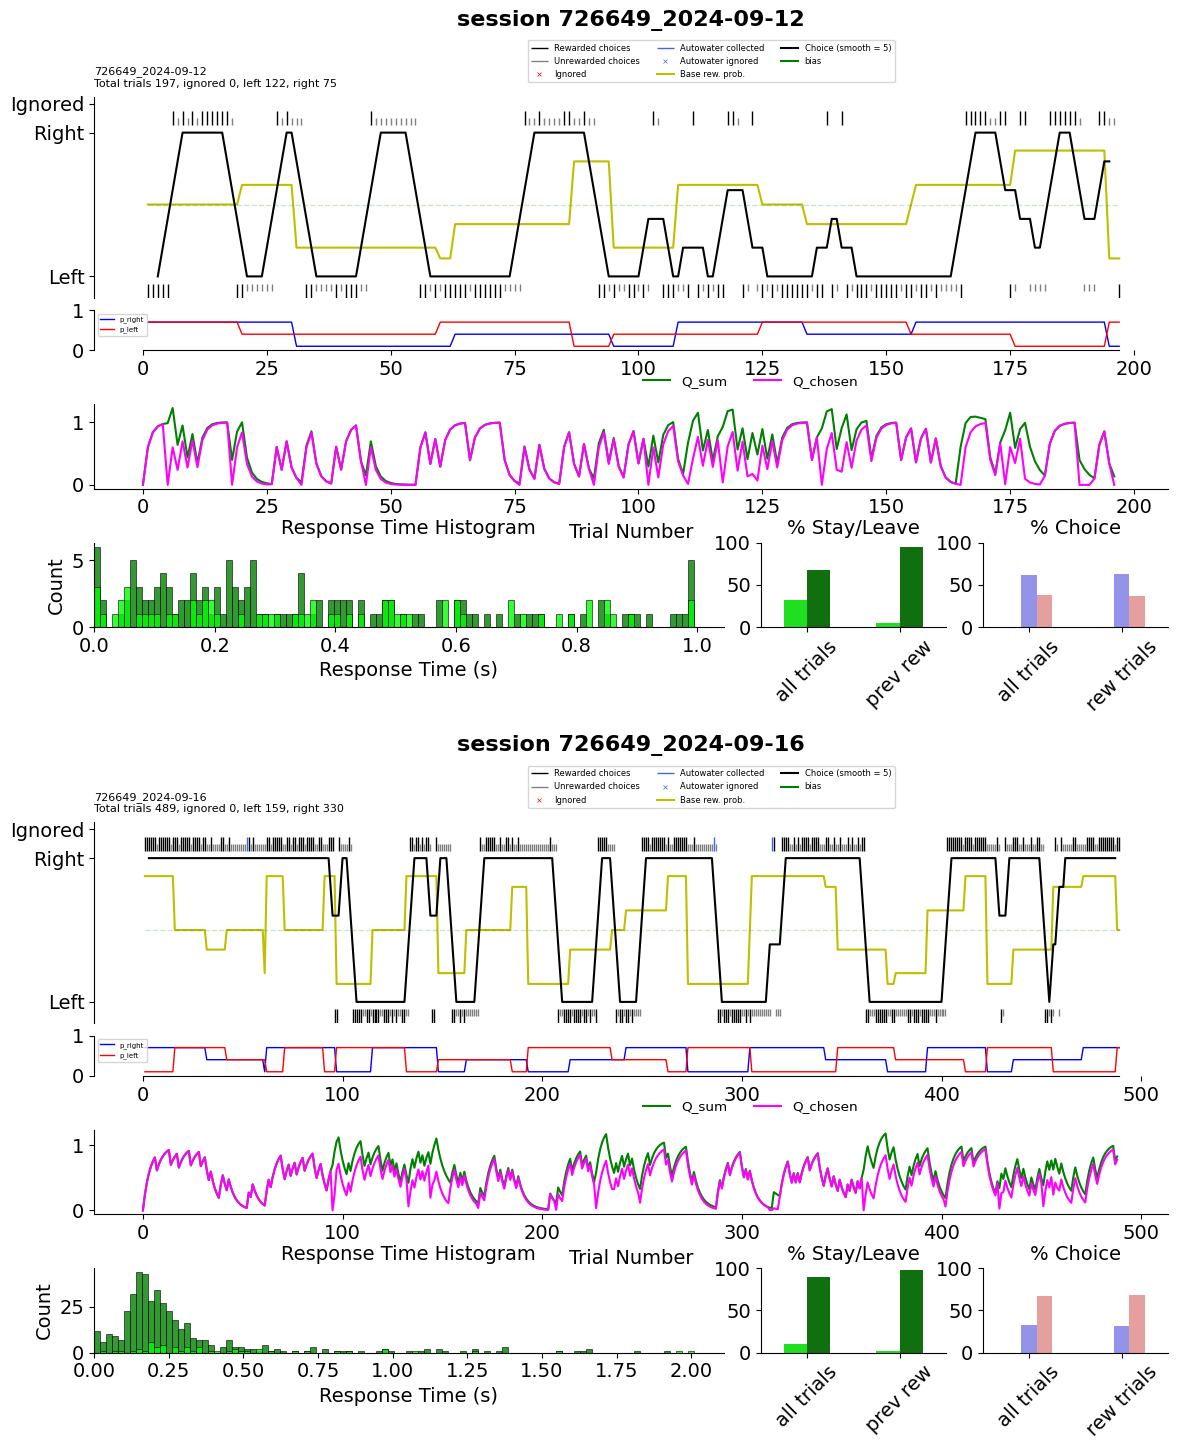

In [75]:
reload(summary_plots)
summary_plots.plot_all_sess(df_sess, nwbs_by_week[0])

2025-12-17 07:34:38,741 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


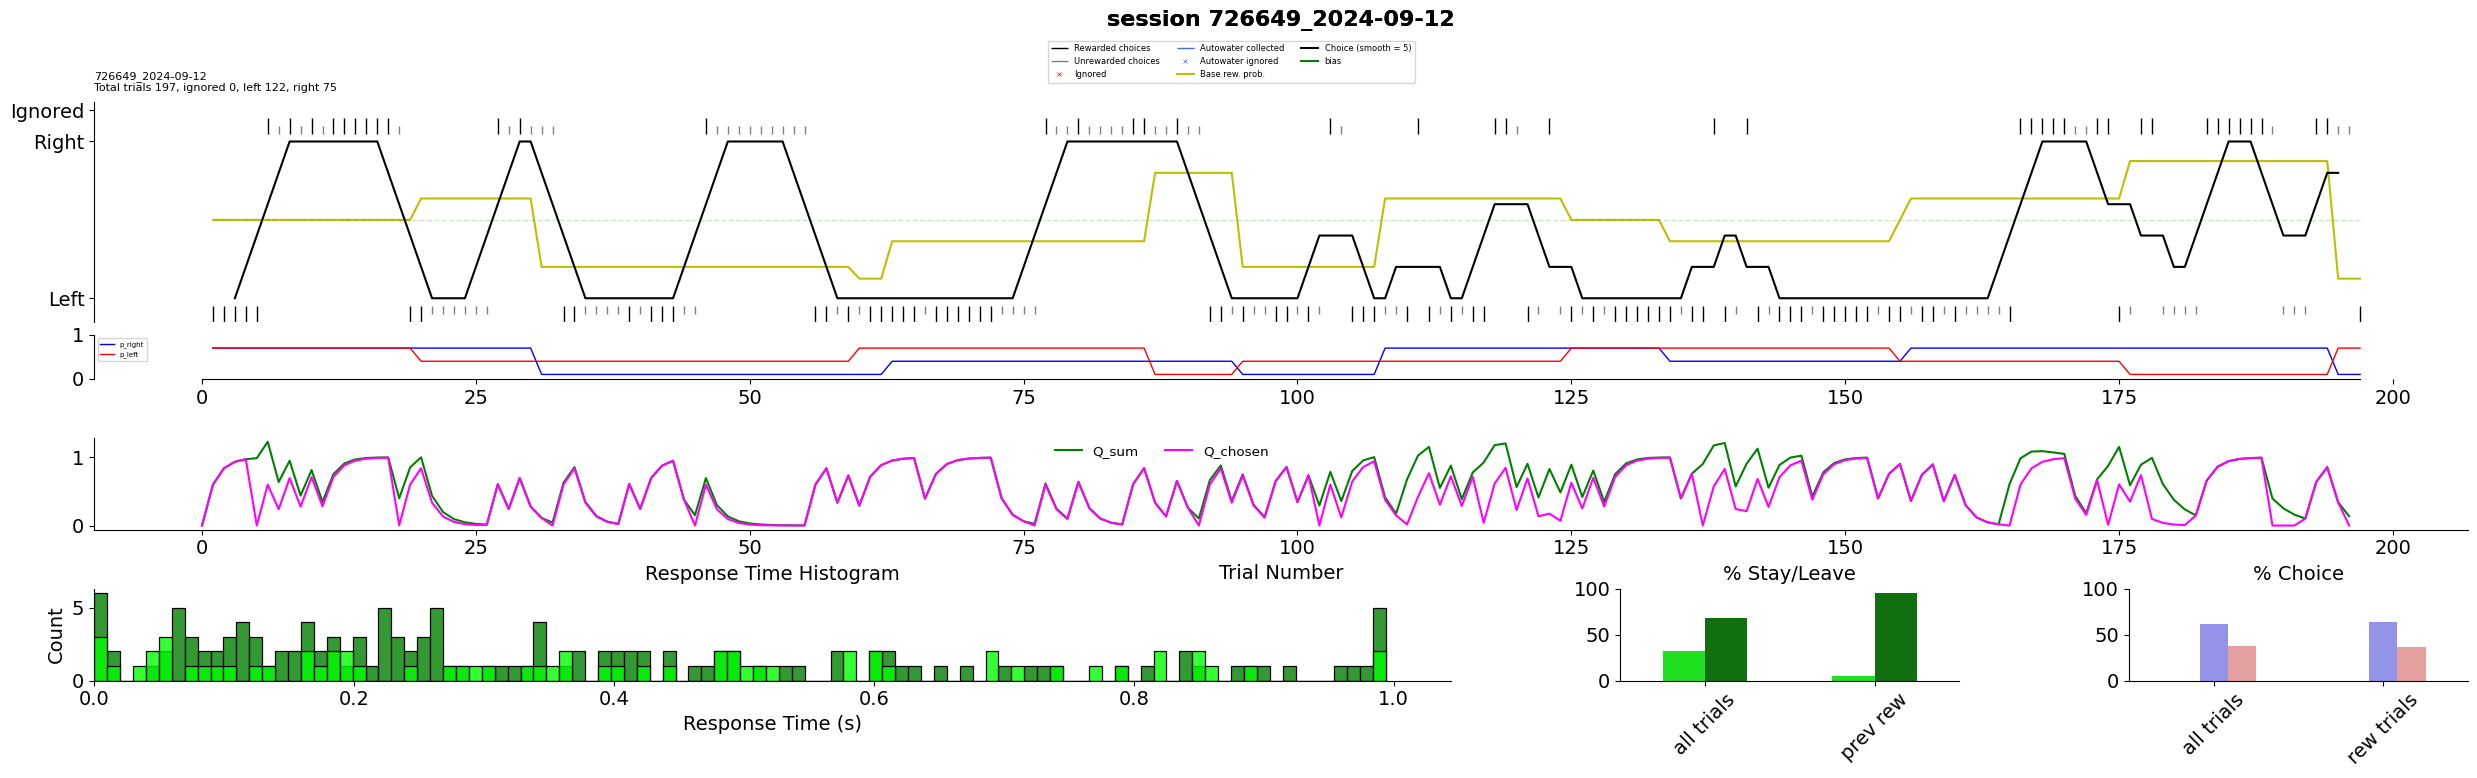

In [74]:
reload(summary_plots)
nwb = nwbs_by_week[0][0]
fig = plt.figure(figsize=(5 * 5, 8))
outer = GridSpec(1, 1, figure=fig)

inner = GridSpecFromSubplotSpec(4, 5,subplot_spec=outer[0], height_ratios=[0.1, 3, 1, 1], wspace = 0.5, hspace = 0.5)
title_ax = fig.add_subplot(inner[0, :])
title_ax.axis('off')
title_ax.set_title(f"{nwb}", fontsize=16, fontweight='bold')


summary_plots.plot_per_sess_behavior_data(nwbs_by_week[0][0], fig, panels = inner)
fig.tight_layout()

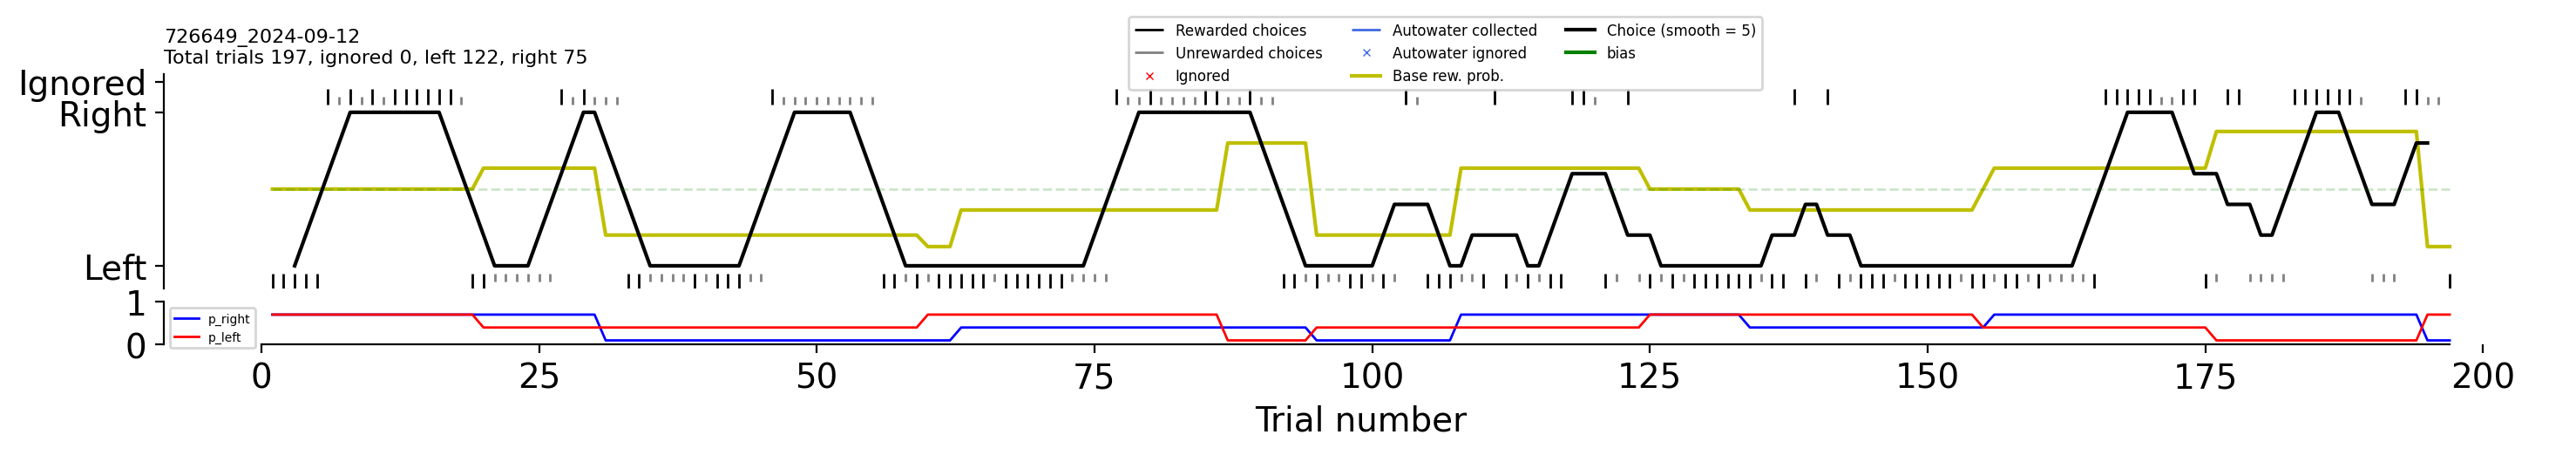

In [9]:

pb.plot_foraging_session_nwb(nwbs_by_week[0][0])

2025-12-15 23:47:24,415 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2025-12-15 23:47:26,532 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2025-12-15 23:47:31,024 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2025-12-15 23:47:32,363 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2025-12-15 23:47:32,576 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-

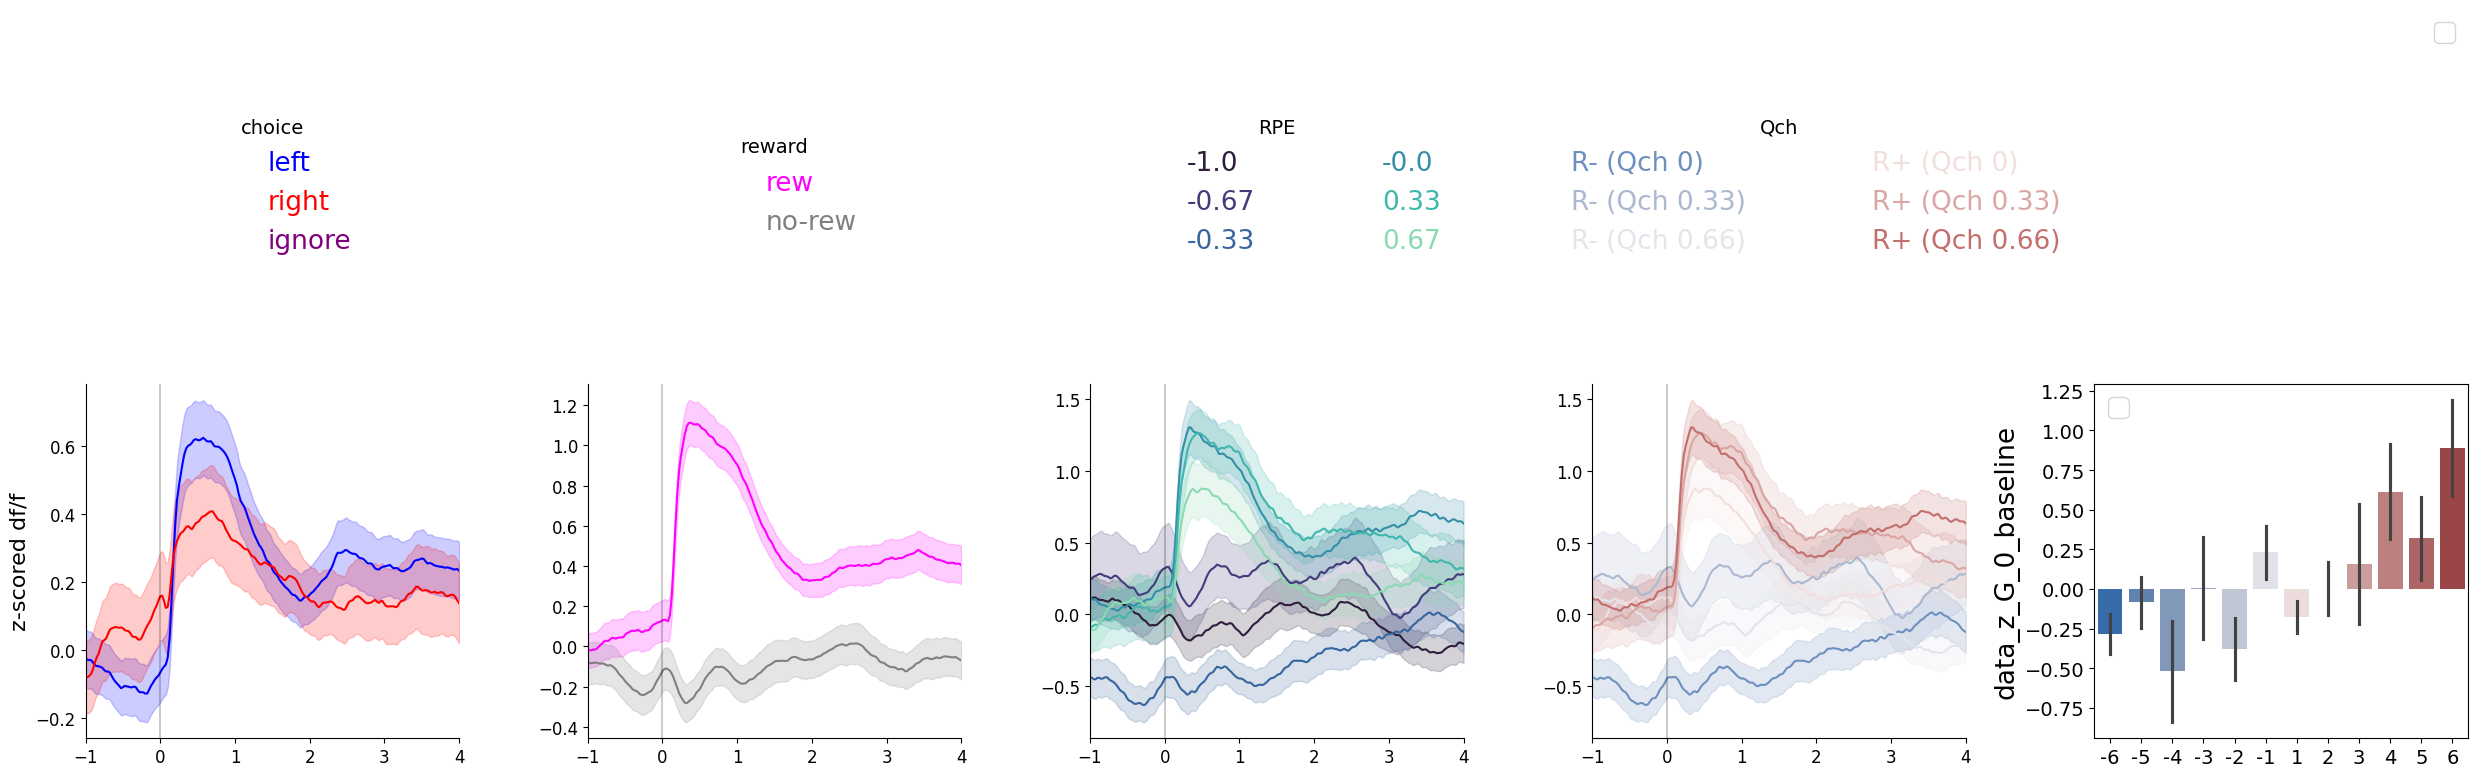

In [40]:
# make figure with 1 row and 5 columns and call the plotting helper
nwb = nwbs_by_week[0][0]
fig = plt.figure(figsize=(5 * 5, 8))

# top row: legend panels (1 x 5)
legend_axes = [fig.add_subplot(2, 5, i + 1) for i in range(5)]
plot_row_panels_PSTH([nwb], "", legend_axes, legend_panel=True)

# bottom row: actual PSTH panels (1 x 5)
psth_axes = [fig.add_subplot(2, 5, 5 + i + 1) for i in range(5)]
plot_row_panels_PSTH([nwb], "G_0", psth_axes, legend_panel=False)

plt.tight_layout()


In [72]:
Qch_binned3_label_names

['R- (Qch 0)',
 'R- (Qch 0.33)',
 'R- (Qch 0.66)',
 'R+ (Qch 0)',
 'R+ (Qch 0.33)',
 'R+ (Qch 0.66)']

In [73]:
nwb.df_trials["Qch-binned3"]

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
192    NaN
193    NaN
194    NaN
195    NaN
196    NaN
Name: Qch-binned3, Length: 197, dtype: category
Categories (6, object): ['R- (Qch 0)' < 'R- (Qch 0.33)' < 'R- (Qch 0.66)' < 'R+ (Qch 0)' < 'R+ (Qch 0.33)' < 'R+ (Qch 0.66)']

In [ ]:
def plot_all_sess(df_sess, nwbs_all, channel, channel_loc, loc=None):
    """
    plot_all_sess the DA version-- 
    plots L/R, split by RPE, baseline, split by RPE after baseline removal, slope for average response. 
    """
    # set pdf plot requirements
    mpl.rcParams['pdf.fonttype'] = 42 # allow text of pdf to be edited in illustrator
    mpl.rcParams["axes.spines.right"] = False
    mpl.rcParams["axes.spines.top"] = False


    nrows = len(nwbs_all)
    ncols = N_COLS_PER_ROW
    subject_id = df_sess['subject_id'].unique()[0]



    fig = plt.figure(figsize=(ncols*5, nrows*4))
    plt.suptitle(f"{subject_id} {channel_loc} ({channel})", fontsize = 16)

    outer = GridSpec(nrows, 1, figure=fig)

    # axes_rows will hold lists of 4 axes for each row; index 0 reserved for the top summary row (unused)
    axes_rows = [None] * nrows

    # -- Plot one row per session --- 
    for row, nwb in enumerate(nwbs_all):

        # create a small title row above the 4 panels using a nested GridSpec
        inner = GridSpecFromSubplotSpec(2, ncols, subplot_spec=outer[row], height_ratios=[0.12, 0.88], hspace=0.0, wspace=0.3)
        title_ax = fig.add_subplot(inner[0, :])
        title_ax.axis('off')
        title_ax.set_title(f"{nwb}", fontsize=16, fontweight='bold')

        # create the n_cols panel axes for this row
        panels = [fig.add_subplot(inner[1, col]) for col in range(ncols)]

        panels = plot_row_panels([nwb], channel, panels)
        axes_rows[row] = panels


    # set bottom row xlabels using the last row panels
    last_panels = axes_rows[-1]
    if last_panels is not None:
        last_panels[2].set_xlabel('num_reward_past')
        last_panels[0].set_xlabel('Time (s) from choice')
        last_panels[1].set_xlabel('Time (s) from choice')
        last_panels[-1].set_xlabel('Time (s) from choice')

    # show legends on the first data row (row index 1) if it exists
    if nrows > 1 and axes_rows[1] is not None:
        for (col, legend_title) in zip([0, 1, 3], ['choice', 'RPE', 'RPE']):
            axes_rows[1][col].legend(framealpha=0.5, title = legend_title, fontsize='small')

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    if loc is not None:
        plt.savefig(f"{loc}all_sess_{subject_id}_{channel}.png",bbox_inches='tight',transparent = False, dpi = 1000)
        plt.close()

,trial,choice,rewarded_historyL,rewarded_historyR,side_bias,side_bias_confidence_interval,bait_left,bait_right,base_reward_probability_sum,reward_probabilityL,...,data_z_G_1_baseline,data_R_0_baseline,data_z_R_0_baseline,reward_all,num_reward_past,RPE-binned3,week_interval,avg_data_z_norm_R_0_choice_time,avg_data_z_norm_G_0_choice_time,avg_data_z_norm_G_1_choice_time
0,0,0.0,True,False,NaN,"[nan, nan]",True,True,0.8,0.7,...,-0.253120,2485.121382,0.714040,True,1,0.67,1,0.078969,1.050893,1.122472
1,1,0.0,True,False,NaN,"[nan, nan]",True,True,0.8,0.7,...,-0.834826,2428.392225,0.596711,True,2,0.33,1,1.150323,3.940241,4.558299
2,2,0.0,True,False,NaN,"[nan, nan]",True,True,0.8,0.7,...,1.712887,3389.024622,2.583516,True,3,-0.0,1,0.350892,1.052745,1.570548
3,3,0.0,True,False,NaN,"[nan, nan]",True,True,0.8,0.7,...,1.205047,3328.141685,2.457596,True,4,-0.0,1,0.756732,2.356876,1.727903
4,4,0.0,True,False,NaN,"[nan, nan]",True,True,0.8,0.7,...,0.635668,3169.831533,2.130175,True,5,-0.0,1,0.570183,2.047199,2.226870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,276,1.0,False,True,NaN,"[nan, nan]",False,True,0.8,0.1,...,-1.325052,1585.814255,-1.145931,True,1,0.67,1,0.014622,0.155704,0.609415
193,285,1.0,False,True,NaN,"[nan, nan]",False,True,0.8,0.1,...,-1.360709,1543.471274,-1.233506,True,1,0.33,1,0.053791,0.063956,0.284147
194,287,1.0,False,False,NaN,"[nan, nan]",True,False,0.8,0.7,...,-1.879338,1636.039741,-1.042053,False,-2,-1.0,1,-0.077024,-0.618143,0.101645
195,296,1.0,False,False,NaN,"[nan, nan]",True,False,0.8,0.7,...,-1.634625,1652.575378,-1.007854,False,-11,-0.67,1,-0.056925,-0.727662,0.025982
